# Importing Module and define directories

In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,StandardScaler, MinMaxScaler
from utils.results import plot_results, output_correlations
from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

# Train - Validation Split

In [2]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = MinMaxScaler()
norm_labels = MinMaxScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)
all_norm_data = np.column_stack((data, labels))

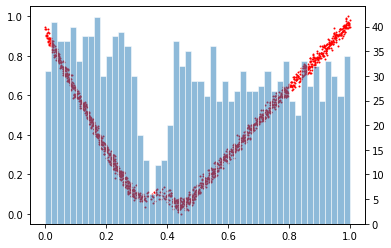

In [3]:
hard_out = labels[:, 1]
easy_out = labels[:, 0]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

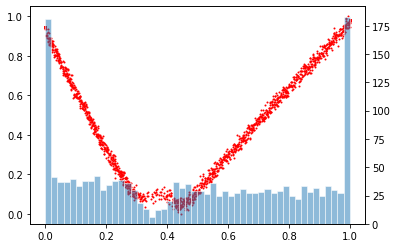

In [4]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def expand_in_middle(n_new_data, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    rng = np.random.default_rng()
    for i in range(n_new_data):
        val = rng.normal(loc = (lim_inf + lim_sup)/2, 
                         scale = np.abs((lim_inf - lim_sup)/2))
        sort_for_val = np.argsort(np.abs(data_copy[:,unbal_feature]-val))
        d1 = sort_for_val[0]
        d2 = sort_for_val[1]
        data_copy = generate_in_middle(data_copy, d1, d2)
    return data_copy

new_dataset = expand_in_middle(150, all_norm_data, 1.3, 1.7, 11)
new_dataset = expand_in_middle(150, new_dataset, -1.6, -1.4, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

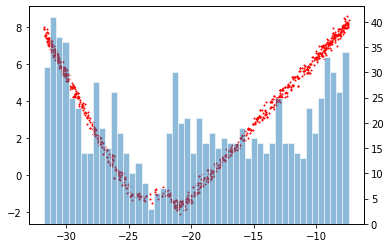

In [5]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def remove_in_middle(n, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    left_data = data_copy[data_copy[:, unbal_feature] < lim_inf]
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    right_data = data_copy[data_copy[:, unbal_feature] > lim_sup]
    rng = np.random.default_rng()
    mid_data = rng.choice(mid_data, size = len(mid_data) - n )
    data_copy = np.row_stack((left_data, mid_data))
    data_copy = np.row_stack((data_copy, right_data))
    return data_copy

new_dataset = remove_in_middle(500, raw_data, -30, -10, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

In [6]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

In [7]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

## Train the model

In [54]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)


train_labels1 = train_labels[:,1].reshape((len(train_labels),1))
val_labels1 = val_labels[:,1].reshape((len(val_labels), 1))

In [55]:
other_output= train_labels[:,0]
lin_output= train_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((input_data, train_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'std')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

In [58]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 50000
lamb=1e-6; batch_size = -1; alpha=0.5 ; nesterov=True ; eta_function=1e-4
beta=0.9
netw = MLP(structure, func=act_func,starting_points=start)

In [59]:
netw.train(input_data, train_labels , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = 100, error_threshold = 0.)

Epoch 9122:  [train MEE = 0.2294]  [val MEE = 0.2718]                              
Elapsed time: 22.743382692337036 s


# Plot results

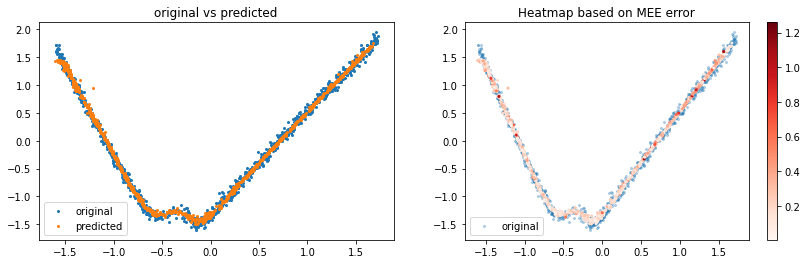

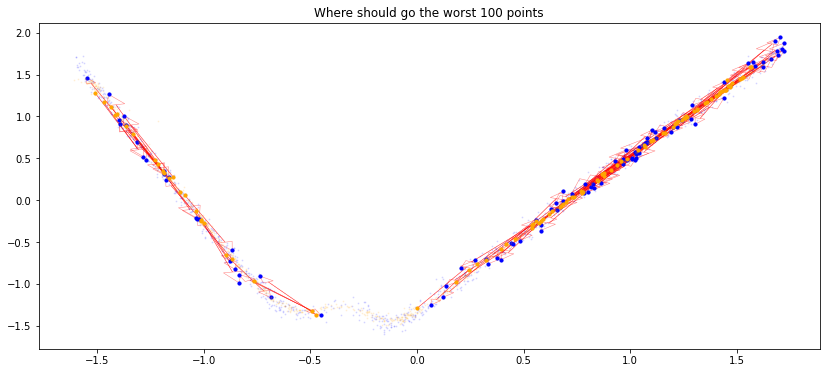

In [60]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

w = output_correlations(netw, input_data, train_labels, plot_arrow_worse = 100,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

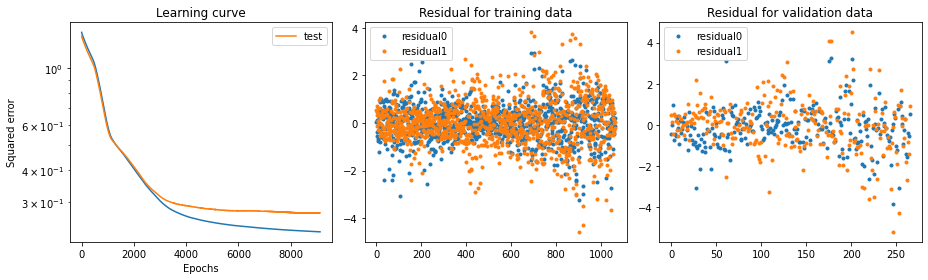

final train error: 0.9753414596686852
final val error: 1.1906537367408656


In [62]:
plot_results(netw, input_data, val_data, train_labels, val_labels, 
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = 1)

## Try an ensemble

In [2]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [11]:
raw_data=np.loadtxt("../../data/Data_set.txt")
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)

#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

structure=[10, labels.shape[-1]]
act_func=["tanh"]*(len(structure)-1) + ["linear"]
start=xavier(structure)

dict_MLP = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}

N_epoch = 2000
lamb=0.#1e-4
batch_size = 50 #-1 for batch gradient descent
alpha=0.3
nesterov=True
eta=5e-5
beta=0.7
dict_train = {'epoch':N_epoch, 'batch_size':batch_size, 'eta':eta, 'lamb':lamb, 
              'alpha':alpha, 'nesterov':nesterov, 'RMSProp':True, 'beta':beta,
              'error_threshold':0., 'patience':100, 'verbose':True}

bagg = bagging_ensemble(5)
bagg.train(input_data, train_labels , val_data, val_labels, 
           MLP, dict_MLP, dict_train, bootstrap = False)

act_func=["lrelu"]*(len(structure)-1) + ["linear"]
dict_MLP_tanh = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}
bagg.train(input_data, train_labels , val_data, val_labels, 
           MLP, dict_MLP_tanh, dict_train, bootstrap = False)

0/5
Epoch 2000:  [train MEE = 0.3015]  [val MEE = 0.3306]                              
Elapsed time: 11.995853424072266 s
1/5
Epoch 2000:  [train MEE = 0.3041]  [val MEE = 0.3225]                              
Elapsed time: 12.057296991348267 s
2/5
Epoch 2000:  [train MEE = 0.3142]  [val MEE = 0.3330]                              
Elapsed time: 12.834224700927734 s
3/5
Epoch 2000:  [train MEE = 0.3280]  [val MEE = 0.3415]                              
Elapsed time: 13.558960437774658 s
4/5
Epoch 2000:  [train MEE = 0.3113]  [val MEE = 0.3280]                              
Elapsed time: 12.836474657058716 s
5/10
Epoch 2000:  [train MEE = 0.3037]  [val MEE = 0.3071]                              
Elapsed time: 12.109868288040161 s
6/10


KeyboardInterrupt: 

In [ ]:
bagg.prune_ensemble

In [ ]:
plot_results(bagg, input_data, val_data, train_labels, val_labels,
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True, 
             norm = norm_labels.inverse_transform, 
             sortidx = 1)

In [ ]:
w_worst = output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

print(w_worst)

In [ ]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 500
lamb=1e-6; batch_size = -1; alpha=0.1 ; nesterov=True ; eta_function=5e-3
beta=0.5
worst_nt = MLP(structure, func=act_func,starting_points=start)

In [ ]:
worst_nt.train(input_data[w_worst], train_labels[w_worst] , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = -1, error_threshold = 0 )